In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import pywt

In [15]:
#Reading Cascade files
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Projects/Image Classification/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Projects/Image Classification/haarcascade_eye.xml')

# **Preprocessing-1: Cropping the Facial region of image if eyes>=2**

In [16]:
def get_cropped_image(path):            #Function to get face if min 2 eyes are visible
    img = cv2.imread(path)              #Reading image from given path
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        #Converting color image to grayscale
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)          #Detecting face
    for(x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+h]
        roi_color = img[y:y+h, x:x+h]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

# **Preprocessing-2: Using wavelet transformation for feature extraction**

In [86]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)
    imArray /= 255;
    # compute coefficients
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)
    coeffs_H[0] *= 0;

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

# **Generating croped image in cropped folder**

In [17]:
path_to_data = '/content/drive/MyDrive/Projects/Image Classification/Datasets'
folder = 'cropped'
path_to_cr_data = os.path.join(path_to_data,folder)
path_to_cr_data

'/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped'

In [18]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['/content/drive/MyDrive/Projects/Image Classification/Datasets/Ronaldo',
 '/content/drive/MyDrive/Projects/Image Classification/Datasets/Kohli',
 '/content/drive/MyDrive/Projects/Image Classification/Datasets/Messi',
 '/content/drive/MyDrive/Projects/Image Classification/Datasets/Sachin',
 '/content/drive/MyDrive/Projects/Image Classification/Datasets/Dhoni']

In [19]:
#Creating cropped folder
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)


In [21]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]

    celebrity_file_names_dict[celebrity_name] = []
    #print(celebrity_name)
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image(entry.path)
        if roi_color is not None:
            cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
            if not os.path.exists(cropped_folder):
                os.mkdir(cropped_folder)
                cropped_image_dirs.append(cropped_folder)

            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = cropped_folder + '/' + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

# **Manually Examined cropped data and deleted irrevalent images**

In [23]:
#Saving the remaining file list after manual removal
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
  celebrity_name = img_dir.split('/')[-1]
  file_list = []
  for entry in os.scandir(img_dir):
    file_list.append(entry.path)
  celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Ronaldo': ['/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo1.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo3.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo4.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo5.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo6.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo7.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo8.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo9.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo10.png',
  '/content/drive/MyDrive/Projects/Image Classification/Datasets/cropped/Ronaldo/Ronaldo11.png',
  '/content/drive/MyDrive/P

In [36]:
#Defing key values for sports person
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Ronaldo': 0, 'Kohli': 1, 'Messi': 2, 'Sachin': 3, 'Dhoni': 4}

# **Generating labeled data combinning both raw images and wavelet transformed images for model training**

In [66]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)      #Reading cropped image
        scalled_raw_img = cv2.resize(img, (32, 32))       #Scailing the cropped images
        img_har = w2d(img,'db1',5)          #wavelet Transformation
        scalled_img_har = cv2.resize(img_har, (32, 32))       #Scaling wavelet transformed image
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])    #Labeling images

In [63]:
len(y)

186

In [70]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(186, 4096)

In [71]:
X[0]

array([42., 26., 20., ...,  2.,  6.,  1.])

# **ML model training**

In [61]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [72]:
#Model Generation Using SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.723404255319149

# **Using Grid search CV to come up with best model and best fine tuned parameters**

In [73]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [74]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [75]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.704497,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.596825,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.697619,{'logisticregression__C': 1}


In [76]:
best_estimators['svm'].score(X_test,y_test)

0.7659574468085106

In [77]:
best_estimators['random_forest'].score(X_test,y_test)

0.5531914893617021

In [78]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8085106382978723

In [79]:
best_clf = best_estimators['svm']

In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[12,  0,  0,  1,  1],
       [ 1,  7,  0,  0,  0],
       [ 2,  0,  6,  0,  0],
       [ 1,  0,  1,  7,  1],
       [ 1,  0,  1,  1,  4]])

Text(95.72222222222221, 0.5, 'Truth')

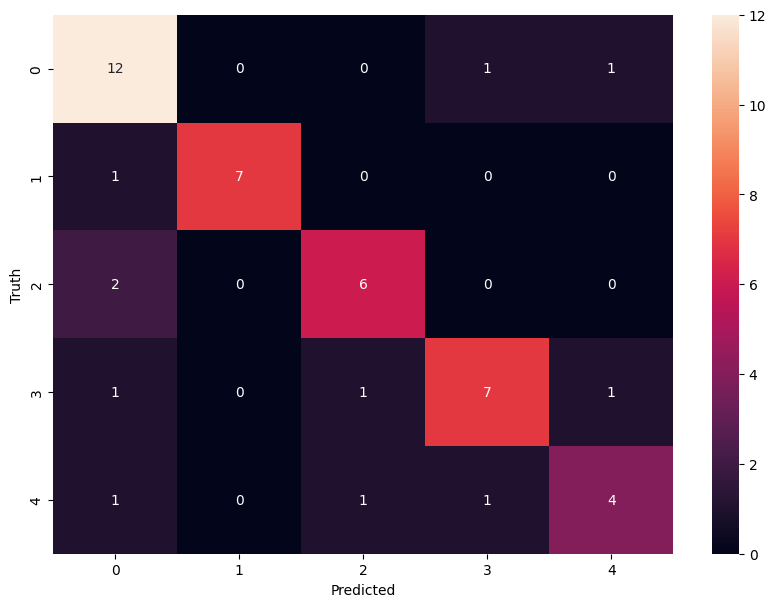

In [81]:
#Generating heat maps
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# **Saving the trained model**

In [84]:
import joblib
# Save the model as a pickle in a file
joblib.dump(best_clf, '/content/drive/MyDrive/Projects/Image Classification/saved_model.pkl')

['/content/drive/MyDrive/Projects/Image Classification/saved_model.pkl']

In [85]:
#Saving Class dict
import json
with open("/content/drive/MyDrive/Projects/Image Classification/class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))